In [327]:
import numpy as np
import pandas as pd

In [328]:
distances = pd.read_csv('monroe_tract_dists.csv')
distances

,tract1,mi_to_tract,tract2
0,200,0.436671,4100
1,200,0.550295,9200
2,200,0.557736,9604
3,200,0.834074,9601
4,200,0.876827,2300
...,...,...,...
37051,990000,31.176584,11708
37052,990000,32.366281,14700
37053,990000,33.374571,12402
37054,990000,34.075776,13300


In [343]:
tract_index_map = {tract: index for index, tract in enumerate(distances['tract1'].unique())}
len(tract_index_map)

193

In [358]:
shape = (len(tract_index_map),) * 2
distance_matrix = np.empty(shape)
distance_matrix

array([[7.29111856e-304, 7.29111856e-304, 7.29111856e-304, ...,
        7.29111856e-304, 7.29111856e-304, 7.29111856e-304],
       [7.29111856e-304, 7.29111856e-304, 7.29111856e-304, ...,
        7.29111856e-304, 7.29111856e-304, 7.29111856e-304],
       [7.29111856e-304, 7.29111856e-304, 7.29111856e-304, ...,
        7.29111856e-304, 7.29111856e-304, 7.29111856e-304],
       ...,
       [7.29111856e-304, 7.29111856e-304, 7.29111856e-304, ...,
        7.29111856e-304, 7.29111856e-304, 7.29111856e-304],
       [7.29111856e-304, 7.29111856e-304, 7.29111856e-304, ...,
        7.29111856e-304, 7.29111856e-304, 7.29111856e-304],
       [7.29111856e-304, 7.29111856e-304, 7.29111856e-304, ...,
        7.29111856e-304, 7.29111856e-304, 7.29111856e-304]])

In [360]:
for i, row in distances.iterrows():
    tract1, distance, tract2 = int(row[0]), row[1], int(row[2])
    index1, index2 = tract_index_map[tract1], tract_index_map[tract2]
    distance_matrix[index1, index2] = distance

distance_matrix

array([[7.29111856e-304, 1.10091284e+000, 2.27336712e+000, ...,
        3.64643507e+000, 5.58978602e+000, 2.08582701e+001],
       [1.10091284e+000, 7.29111856e-304, 1.80152102e+000, ...,
        4.70837869e+000, 4.58731398e+000, 2.03089283e+001],
       [2.27336712e+000, 1.80152102e+000, 7.29111856e-304, ...,
        4.94975937e+000, 5.39116814e+000, 2.17400775e+001],
       ...,
       [3.64643507e+000, 4.70837869e+000, 4.94975937e+000, ...,
        7.29111856e-304, 9.22929389e+000, 2.37193039e+001],
       [5.58978602e+000, 4.58731398e+000, 5.39116814e+000, ...,
        9.22929389e+000, 7.29111856e-304, 1.67197127e+001],
       [2.08582701e+001, 2.03089283e+001, 2.17400775e+001, ...,
        2.37193039e+001, 1.67197127e+001, 7.29111856e-304]])

In [326]:
tracts = set()
with open('monroe_vaccine_tracts_short.txt') as file:
    for line in file:
        tracts |= {int(line.strip())}

tracts

{1000,
 2000,
 2200,
 2400,
 3000,
 3100,
 3805,
 3900,
 5200,
 5400,
 5800,
 7100,
 7700,
 7801,
 8000,
 8100,
 8200,
 9302,
 9400,
 9601,
 9603,
 10100,
 10400,
 10601,
 10602,
 10800,
 10901,
 11208,
 11400,
 11501,
 11601,
 11603,
 11705,
 11706,
 12301,
 12401,
 12700,
 12800,
 13101,
 13104,
 13204,
 13206,
 13506,
 13507,
 13601,
 13702,
 14001,
 14004,
 14102,
 14103,
 14104,
 14203,
 14301,
 14302,
 14400,
 14504,
 14505,
 14602,
 14700,
 14901,
 14906,
 15303,
 15304,
 15400,
 980000}

In [362]:
from simanneal import Annealer
import random, math
import csv
from collections import defaultdict

class ClinicFinder(Annealer):
    def __init__(self, state, distance_matrix, population, risk, clinic_amount):
        self.distance_matrix = distance_matrix
        self.max_dist = -1
        for x in distance_matrix:
            #print(x)
            for y in distance_matrix[x]:
                #print(y)
                if self.max_dist < distance_matrix[x][y]:
                    self.max_dist = distance_matrix[x][y]
        #self.max_dist = max([distance_matrix[x][y] for x in distance_matrix for y in x])
        self.population = population
        self.risk = risk
        self.clinic_amount = clinic_amount
        super(ClinicFinder, self).__init__(state)

    def move(self):
        a = random.randint(0, self.clinic_amount - 1)
        b = random.randint(self.clinic_amount, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]


    def energy(self):
        e = 0
        for i in range(self.clinic_amount,len(self.state)):
            min = 1000000000.0
            for j in range(self.clinic_amount):
                if self.distance_matrix[self.state[i]][self.state[j]] <  min:
                    min = self.distance_matrix[self.state[i]][self.state[j]]
            #e += min / self.max_dist + self.risk[self.state[i]]    # Metric 3
            e += min * self.risk[self.state[i]]                     # Metric 1
            #e += (1 + self.risk[self.state[i]]) ** min              # Metric 2
            #e += min ** (self.risk[self.state[i]])               # Metric 4
        return e

In [363]:
file = open('./annealer/monroe_tracts.csv','r')
reader = csv.DictReader(file)
line_count = 0
risk = {}
population = {}
tracts = []
for row in reader:
    if line_count != 0:
        risk[row['tract']] =  float(row['ccvi'])
        population[row['tract']] =  float(row['pop_est'])
        tracts.append(row['tract'])
    line_count+=1
file2 = open('./annealer/monroe_tract_dists.csv','r')
reader2 = csv.DictReader(file2)
distance_matrix = defaultdict(dict)
for row in reader2:
    if line_count != 0:
        distance_matrix[row['tract1']][row['tract2']] = float(row['mi_to_tract'])
    line_count += 1
random.shuffle(tracts)

CF = ClinicFinder(tracts,distance_matrix,population,risk,65)
CF.Tmax = 500.0
print(CF.clinic_amount)
print(CF.state)


65
['13603', '8301', '6800', '6200', '13001', '14602', '14804', '6600', '12800', '13702', '14505', '15303', '2000', '7600', '9601', '12201', '13604', '14906', '13401', '13506', '14004', '2700', '8702', '11705', '14204', '11504', '14803', '1900', '3300', '5000', '8100', '14905', '14003', '14503', '11505', '700', '15200', '9302', '8500', '6700', '2300', '13002', '10901', '13205', '13300', '14601', '14802', '4100', '6400', '11100', '12500', '3200', '12304', '11503', '14103', '12301', '6000', '10602', '14903', '6900', '11207', '3805', '4701', '11703', '14700', '8600', '10902', '14001', '5500', '13601', '7000', '9603', '4900', '11604', '3500', '9301', '15400', '8400', '11603', '2200', '12100', '12306', '14202', '8200', '13901', '11203', '11601', '5400', '6500', '10601', '10500', '11501', '7100', '9602', '15304', '13508', '7700', '8701', '10200', '12700', '1000', '1300', '13204', '13503', '10800', '13203', '15301', '15000', '2400', '11205', '4800', '11707', '10700', '5200', '11902', '3400', 

In [364]:
states, utility = CF.anneal()
states_copy = [x for x in states]

print(states)
print(utility)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         81.70    87.60%    44.20%     0:00:54     0:00:00

['6200', '9500', '12900', '15102', '8000', '9301', '4701', '12100', '8100', '14906', '13603', '11505', '10800', '5800', '11203', '11400', '1000', '6300', '4800', '15304', '14505', '13901', '14901', '2100', '8701', '14802', '11603', '14004', '11503', '12301', '13203', '9200', '3400', '13103', '10601', '14601', '12401', '15200', '12306', '7000', '13206', '13506', '15101', '11800', '5600', '13205', '14203', '14202', '3100', '14400', '11501', '14102', '1300', '8500', '12304', '1900', '12700', '14903', '13503', '9302', '14104', '4702', '14700', '14503', '7600', '7801', '11605', '12000', '11703', '5000', '6700', '11302', '12402', '14905', '12202', '11208', '5900', '13001', '13902', '7900', '6400', '12600', '10200', '2300', '8600', '13505', '13401', '7700', '6500', '3805', '13300', '8400', '11705', '4900', '6800', '9400', '3900', '13508', '14301', '2200', '3000', '14602', '5100', '6900', '12800', '700', '13402', '13002', '10100', '11504', '11708', '11901', '10400', '9603', '5700', '13507', '1

In [ ]:
f = open("monroe_vaccine_tracts_short.txt", "r")
unique0 = {x.strip() for x in f}
#print(len(unique))
index0 = 0
for x in unique0:
    for i in range(len(states)):
        if x == states[i]:
            states[index0], states[i] = states[i], states[index0]
            index0 = index0 + 1
            break

e = 0
e_orig = {}
orig_min_dist_avg = 0
for i in range(65,len(states)):
    min = 1000000000.0
    for j in range(65):
        if distance_matrix[states[i]][states[j]] <  min:
            min = distance_matrix[states[i]][states[j]]
            
    orig_min_dist_avg += min
    #e += (1 + risk[states[i]]) ** min
    #e_orig[states[i]] = (1 + risk[states[i]]) ** min
    e += min * risk[states[i]]
    e_orig[states[i]] = min * risk[states[i]]
    #e += min / CF.max_dist + risk[states[i]]
    #e_orig[states[i]] = min / CF.max_dist + risk[states[i]]
    #e += min ** (risk[states[i]])
    #e_orig[states[i]] = min ** (risk[states[i]])
print(e)
orig_min_dist_avg /= len(states) - 65

In [365]:
f = open("quantum2.txt", "r")
unique = {x.strip() for x in f}
#print(len(unique))
index = 0
for x in unique:
    for i in range(len(states)):
        if x == states[i]:
            states[index], states[i] = states[i], states[index]
            index = index + 1
            break

#print(states)
#print(unique)
e = 0
e_orig = {}
orig_min_dist_avg = 0
for i in range(65,len(states)):
    min = 1000000000.0
    for j in range(65):
        if distance_matrix[states[i]][states[j]] <  min:
            min = distance_matrix[states[i]][states[j]]
            
    orig_min_dist_avg += min
    #e += (1 + risk[states[i]]) ** min
    #e_orig[states[i]] = (1 + risk[states[i]]) ** min
    e += min * risk[states[i]]
    e_orig[states[i]] = min * risk[states[i]]
    #e += min / CF.max_dist + risk[states[i]]
    #e_orig[states[i]] = min / CF.max_dist + risk[states[i]]
    #e += min ** (risk[states[i]])
    #e_orig[states[i]] = min ** (risk[states[i]])
print(e)
orig_min_dist_avg /= len(states) - 65
    
e = 0
e_new = {}
new_min_dist_avg = 0
for i in range(65,len(states_copy)):
    min = 1000000000.0
    for j in range(65):
        if distance_matrix[states_copy[i]][states_copy[j]] <  min:
            min = distance_matrix[states_copy[i]][states_copy[j]]
    
    new_min_dist_avg += min
    #e += (1 + risk[states_copy[i]]) ** min
    #e_new[states_copy[i]] = (1 + risk[states_copy[i]]) ** min
    e += min * risk[states_copy[i]]
    e_new[states_copy[i]] = min * risk[states_copy[i]]
    #e += min / CF.max_dist + risk[states_copy[i]]
    #e_new[states_copy[i]] = min / CF.max_dist + risk[states_copy[i]]
    #e += min ** (risk[states_copy[i]])
    #e_new[states_copy[i]] = min ** (risk[states_copy[i]])
    
new_min_dist_avg /= len(states) - 65

for i in range(65):
    e_orig[states[i]] = 0
    e_new[states_copy[i]] = 0

deltas = defaultdict()
for x in e_new:
    deltas[x] = (e_orig[x] - e_new[x])
    
print(orig_min_dist_avg)
print(new_min_dist_avg)

89.70363396287614
1.60252296488581
1.1962180165256953


In [366]:
for i in range(65):
    e_orig[states[i]] = 0
    e_new[states_copy[i]] = 0

In [367]:
deltas = defaultdict()
for x in e_new:
    #deltas[x] = (e_new[x] - e_orig[x])
    deltas |= {x: e_orig[x] - e_new[x]}
    #print(deltas[x], x)

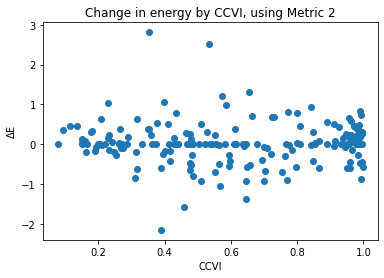

In [271]:
import numpy as np
import matplotlib.pyplot as plt

ccvi = []
delta = []
distances = []
for x in risk:
    ccvi.append(risk[x])
    delta.append(deltas[x])
        
    
ccvi = np.array(ccvi)
delta = np.array(delta)

plt.scatter(ccvi, delta)
plt.xlabel('CCVI')
plt.ylabel('ΔE')
plt.title('Change in energy by CCVI, using Metric 2')
plt.savefig('scatterplot_quantum.png')

Explanation of what this does:   

In [319]:
delta_values = list(deltas.values())

q1 = np.quantile(delta_values, 0.25)
q3 = np.quantile(delta_values, 0.75)
iqr = q3 - q1
q1, q3, iqr

(-0.04147004329297552, 0.021901727150213178, 0.0633717704431887)

In [320]:
temp_dict = {}
for tract in deltas:
    if ((deltas[tract]  > q1 - 1.5 * iqr) and (deltas[tract] < q3 + 1.5 * iqr)):
        temp_dict[tract] = deltas[tract]

In [321]:
from statistics import mean, median

def get_bins(d_dict: dict[float], num_bins: int) -> list[list[float]]:
    bins = [[] for _ in range(num_bins)]

    for tract in d_dict:
        b, i, j = 0, 0, (1 / num_bins)
        binned = False
        while not binned:
            if i < risk[tract] < j:
                bins[b].append(d_dict[tract])
                binned = True
            else:
                b, i, j = (b + 1), j, (j + 1 / num_bins)

    return bins

In [322]:
bins = get_bins(temp_dict, 3)
means = [mean(b) for b in bins]
medians = [median(b) for b in bins]
counts = [len(b) for b in bins]
means, medians, counts

([-0.006738738850928529, -0.0029169203481464413, 0.0013802788228353463],
 [0.0, 0, 0.0],
 [29, 39, 36])

In [323]:
xs = np.array([str(i) for i in range(len(bins))])
ys = np.array(means)
zs = np.array(counts)
ws = np.array(medians)

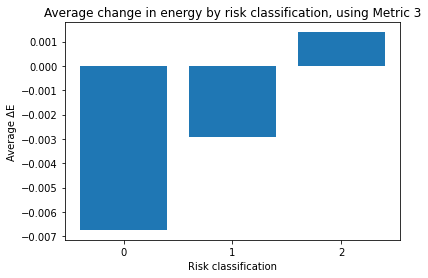

In [324]:
plt.bar(xs, means)
plt.xlabel('Risk classification')
plt.ylabel('Average ΔE')
plt.title('Average change in energy by risk classification, using Metric 3')
plt.savefig('barplot_metric3.png')

Text(0.5, 1.0, 'CCVI Frequency')

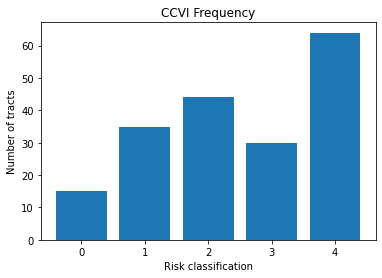

In [221]:
plt.bar(xs, counts)
plt.xlabel('Risk classification')
plt.ylabel('Number of tracts')
plt.title('CCVI Frequency')
#plt.savefig('barplot_metric1.png')

In [88]:
d = [(x, deltas[x]) for x in deltas]
d = sorted(x, key=lambda x: x[1])
with open('deltas.txt', 'w') as f:
    for x, dx in d:
        f.write(f'{x}, {dx}\n')

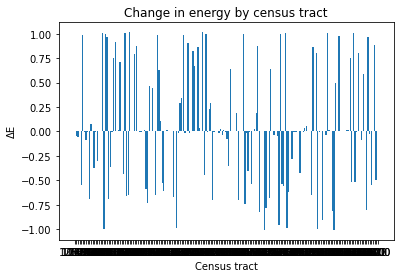

In [102]:


shuffled_deltas = [(x, deltas[x]) for x in deltas]
random.shuffle(shuffled_deltas)

keys = [x for x, y in shuffled_deltas]
values = [y for x, y in shuffled_deltas]
plt.bar(keys, values)
plt.xlabel('Census tract')
plt.ylabel('ΔE')
plt.title('Change in energy by census tract')
plt.savefig('barplot.png')